In [35]:
import numpy as np                  # Data
import pandas as pd                 # Data  
import matplotlib.pyplot as plt     # Plot
import matplotlib.ticker as ticker  # Plot

In [36]:
plt.rcParams.update({
    "text.usetex": True,                # Use LaTeX for text
    "font.family": "serif",             # Use 'serif' font
    "font.serif": ["Computer Modern"],  # LaTeX default font
    "axes.labelsize": 12,               # Font size for labels
    "font.size": 12,                    # General font size
    "legend.fontsize": 11,              # Font size for legend
    "xtick.labelsize": 10,              # Font size for x-axis
    "ytick.labelsize": 10               # Font size for y-axis
})

# Methodology

### Define the drought identification method

In [37]:
def identify_drought(time_series: pd.Series,threshold:float):
    events_thresh = time_series<threshold
    raw_events = events_thresh.groupby(events_thresh.ne(events_thresh.shift()).cumsum()).cumsum()
    identified_events = raw_events[(raw_events.shift(1) < raw_events) & (raw_events.shift(-1) < raw_events)]
    identified_events.index = pd.Index([date - pd.Timedelta(identified_events.loc[date]-1, unit='h') for date in identified_events.index])
    return identified_events

### Verification data 

In [38]:
# Read CSV file containing Capacity Factor from EirGrid wind
cf_pv = pd.read_csv('../Data/verification_cf_pv_1823.csv',
                         index_col = 0,
                         parse_dates = True)

cf_pv.columns = 'pv_eirgrid', 'pv_atlite', 'pv_c3se_national', 'pv_c3se_gridded'

cf_pv_avg = cf_pv.rolling('D', min_periods=24, center=True).mean()
cf_pv_avg

,pv_eirgrid,pv_atlite,pv_c3se_national,pv_c3se_gridded
time,,,,
2018-01-01 00:00:00,NaN,NaN,NaN,NaN
2018-01-01 01:00:00,NaN,NaN,NaN,NaN
2018-01-01 02:00:00,NaN,NaN,NaN,NaN
2018-01-01 03:00:00,NaN,NaN,NaN,NaN
2018-01-01 04:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2023-12-31 19:00:00,NaN,NaN,NaN,NaN
2023-12-31 20:00:00,NaN,NaN,NaN,NaN
2023-12-31 21:00:00,NaN,NaN,NaN,NaN


Detect droughts for PV

In [39]:
droughts_dict = {}

for column_pv in cf_pv_avg:
    raw_droughts_pv = identify_drought(cf_pv_avg[column_pv], 0.1)
    droughts_pv = raw_droughts_pv[raw_droughts_pv > 24]
    droughts_df_pv = pd.DataFrame(droughts_pv)
    droughts_df_pv = droughts_df_pv.set_axis(['Duration'], axis=1)
    droughts_dict[column_pv] = droughts_df_pv

## Plots

In [40]:
def my_title(ax, title):
    ax.set_title(title, x=0.5, y=0.945, transform=ax.transAxes, fontsize=16, 
                 bbox=dict(facecolor='white', alpha=1))

In [41]:
bar_width = 0.2
xlabel = ['1-2','2-3','3-4','4-5','5-6','6-7', '7-8','8+', '']

# Define duration ranges in hours
duration_ranges_hours = [24, 48, 72, 96, 120, 144, 168, 192 ,np.inf]

# Convert duration ranges to days
duration_ranges_days = [dur / 24 for dur in duration_ranges_hours]

# Group datasets based on categories
categories = {
    'pv': ['pv_eirgrid', 'pv_atlite', 'pv_c3se_gridded', 'pv_c3se_national']
}

label_name = ['EirGrid', 'Atlite', 'C3S-E Gridded', 'C3S-E National']
color_models = ['black', '#B03024', '#348ABD', '#988ED5']

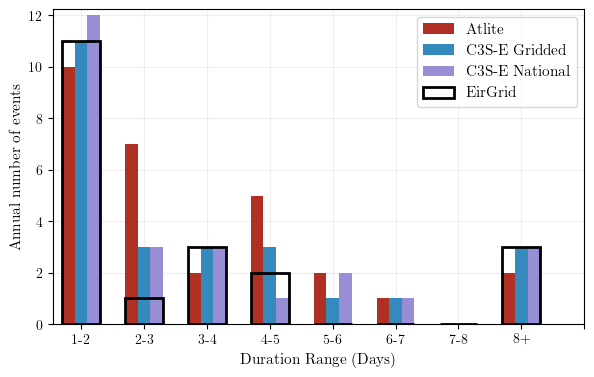

In [42]:
eirgrid_heights = None
positions = np.arange(len(duration_ranges_days) - 1)

cm = 1 / 2.54
fig, ax = plt.subplots(1, 1, 
                       figsize=(15.5*cm, 10*cm),
                       sharey=True)

# Loop over categories for PV
for i, name in enumerate(categories['pv']):
    df = droughts_dict[name]
    df = df.loc['2023', :]

    # Calculate number of events for each duration range
    df['DurationRange'] = pd.cut(df['Duration'], bins=duration_ranges_hours)
    df['Year'] = df.index.year
    annual_counts = df.groupby(['Year', 'DurationRange'], observed=True).size().unstack(fill_value=0)

    all_duration_ranges = pd.cut([], bins=duration_ranges_hours).categories
    annual_counts = annual_counts.reindex(columns=all_duration_ranges, fill_value=0)

    if i == 0:
        eirgrid_heights = annual_counts.values[0]
    else:
        ax.bar(positions + (i - 1) * bar_width - 0.2,
               annual_counts.values[0],
               width=bar_width,
               color=color_models[i],
               label=label_name[i],
               zorder=2)

if eirgrid_heights is not None:
    ax.bar(positions,
           eirgrid_heights,  
           width=bar_width * 3,        
           facecolor='none',
           edgecolor='black',
           linewidth=2,
           label='EirGrid',
           zorder=3)

ax.legend(loc='upper right', fontsize=11)
ax.margins(0.02)
ax.grid(True, alpha=0.2, zorder=0)

# Set x-axis ticks and labels
ax.set_xticks(np.arange(len(duration_ranges_days)))
ax.set_xticklabels(xlabel)
ax.yaxis.set_major_locator(ticker.IndexLocator(base=2, offset=0))

ax.set_ylabel('Annual number of events', fontsize=11)
ax.set_xlabel('Duration Range (Days)', fontsize=11)
fig.tight_layout()
fig.savefig('verification_pv_number_events.pdf', dpi=300)